<a href="https://colab.research.google.com/github/azganushpoghosyan/nlp/blob/master/detecting_fake_job_postings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
!pip install langid
!pip install --upgrade nltk

In [92]:
# Importing libraries
import pandas as pd
import numpy as np
import nltk
import spacy
from nltk.stem import WordNetLemmatizer
from textblob import Word, TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')
import re
import zipfile
import concurrent.futures
import langid
from collections import Counter  # Useful for counting occurrences of elements in a collection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # For transforming text data into numerical features
from gensim.models import Word2Vec  # Used for word embedding, capturing semantic relationships between words
from gensim.models.phrases import Phrases, Phraser  # For detecting common phrases (bigrams) in a corpus
from gensim.utils import simple_preprocess  # Utility for tokenizing text into words
import zipfile
import io
from io import BytesIO
from zipfile import ZipFile
import requests
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report,
                             confusion_matrix,roc_curve, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

import pickle

In [3]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('vader_lexicon', quiet=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

#Useful functions for data preprocessing

In [4]:
def text_preprocessing(text, result = 'no_stopwords'):
    """
    Preprocesses the raw text applying the following steps: convert to string, remove newline characters, standardize, remove numbers, punctuation and stopwords.

    Parameters:
    - text (str): The raw text to be preprocessed.
    - result (str): The step to include in the output. Possible values: 'text', 'combined_text', 'standardized_text', 'no_punctuation',
                                                                        'no_numbers', 'no_stopwords'.
                    Default is 'no_stopwords'.

    Returns:
    - str: The result of the specified step applied.
    """
    text = str(text)
    if result == 'text':
      return text
    # remove newline characters
    combined_text = text.replace('\n', ' ')
    if result == 'combined_text':
      return combined_text

    # standardization of letters (make lowercase)
    standardized_text = combined_text.lower()
    if result == 'standardized_text':
      return standardized_text

    # remove punctuation
    no_punctuation = re.sub(r'[^\w\s]', '', standardized_text)
    if result == 'no_punctuation':
      return no_punctuation

    # remove numbers
    no_numbers = re.sub(r'\d', '', no_punctuation)
    if result == 'no_numbers':
      return no_numbers

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    no_stopwords = " ".join([word for word in no_numbers.split() if word not in stop_words])
    if result == 'no_stopwords':
      return no_stopwords

def text_stemming_lemmatization(text, result = 'clean_tokens'):
    """
    Preprocesses the preprocessed text without stopwords applying the following steps: stemming, lemmitization, final cleanup by removing empty and single-letter strings.

    Parameters:
    - text (str): The text without stopwords to be further preprocessed.
    - result (str): The step to include in the output. Possible values: 'tokens', 'stemmed_tokens', 'lemmatized_tokens', 'clean_tokens'.
                    Default is 'clean_tokens'.

    Returns:
    - list: The result of the specified step applied.
    """
    # spacy tokenization
    nlp = spacy.load('en_core_web_sm')
    doc_tokenize = nlp(text)
    tokens = [token.text for token in doc_tokenize]
    if result == 'tokens':
      return tokens

    # stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    if result == 'stemmed_tokens':
      return stemmed_tokens

    # lemmatization
    sentence = " ".join(tokens)
    doc_lemmitize = nlp(sentence)
    lemmatized_tokens = [token.lemma_ for token in doc_lemmitize]
    if result == 'lemmatized_tokens':
      return lemmatized_tokens

    # final cleaning: remove empty strings, single letters.
    clean_tokens = [token for token in list(lemmatized_tokens) if token.strip() != '' and len(token) > 1]
    if result == 'clean_tokens':
      return clean_tokens

def is_eng(text):
    """
    Checks if the input text is in the English language.

    Parameters:
    - text (str): The input text to be checked for English language.

    Returns:
    - bool: True if the text is identified as English, False otherwise.
    """
    text = str(text)
    # Detects the language of the text
    lang, confidence = langid.classify(str(text))

    # Check if the language is English
    return lang == 'en'

def parallel_processing(iterable, processing_function, *processing_args, workers=3):
    """
    Process elements in parallel using ThreadPoolExecutor.

    Parameters:
    - iterable (iterable): The iterable containing elements to be processed.
    - processing_function (function): The processing function to apply to the elements.
    - processing_args: Additional arguments to pass to the processing function.
    - workers (int, optional): The number of parallel workers. Default is 3.

    Returns:
    - list: A list of processed elements after applying the specified processing function in parallel.
    """
    with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
        processed_elements = list(executor.map(lambda element: processing_function(element, *processing_args), iterable))

    return processed_elements

#Create a model using external labeled dataset

###Import labeled dataset and explore

In [7]:
# Get labeled dataset
zip_url = "https://github.com/azganushpoghosyan/nlp/raw/master/detecting_fake_job_postings_project/data/labeled_dataset.csv.zip"
# Send a GET request to the URL
response = requests.get(zip_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Extract the content of the zip file
    with ZipFile(BytesIO(response.content)) as zip_file:
        # Specify the file you want to extract from the zip archive
        file_to_extract = "labeled_dataset.csv"

        # Extract the file and load it into a Pandas DataFrame (assuming it's a CSV file)
        with zip_file.open(file_to_extract) as f:
            # Now you can use the file (e.g., load it into a Pandas DataFrame)
            # For example:
            # import pandas as pd
            df_raw = pd.read_csv(f)
            print(f"{file_to_extract} has been successfully loaded.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

labeled_dataset.csv has been successfully loaded.


In [8]:
df_raw.shape

(17880, 18)

In [9]:
# Devide data into features and target
X = df_raw.drop('fraudulent', axis=1)
y = df_raw['fraudulent']

# Define the undersampler
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Perform undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Combine the undersampled data back into a DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='fraudulent')], axis=1)

In [10]:
data = df_resampled.copy()
print("Shape: ", data.shape)

data.head()

Shape:  (1732, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,5231,SEM Coordinator,"GR, I, Athens",NaN,NaN,#URL_c379aa631173ed5b7c345ab3f500a9a053e509138...,The right candidate will be responsible for co...,- Previous experience of minimum 3 years...,- Attractive Remuneration Package.- ...,0,1,1,Full-time,NaN,NaN,NaN,NaN,0
1,14113,Senior Data Scientist,"GB, LND, London",Engineering,NaN,"As a growing and successful startup, Conversoc...",Conversocial builds software that helps compan...,Good working knowledge of Python or similar la...,Salary of £40-55k plus stock options£2k annual...,0,1,0,NaN,NaN,NaN,NaN,Engineering,0
2,3169,Junior Web Marketing Specialist,"GR, I, Ilion",Web Marketing και Social,NaN,Η Atnet Communications A.E. είναι μια αμιγώς ε...,Η Atnet Communications αναζητά Junior Web Mark...,Απαιτούμενα προσόντα:Hands-on εμπειρία στην δι...,H θέση αφορά μόνιμη απασχόληση στην περιοχή το...,0,1,1,Full-time,Entry level,NaN,Marketing and Advertising,Marketing,0
3,14805,New Product Development Project Leader - Full ...,"US, GA, Atlanta",NaN,NaN,We Provide Full Time Permanent Positions for m...,Coordination and project management of New Pro...,"Location - Atlanta, GA, USAJob Type – Permanen...",NaN,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Management Consulting,Management,0
4,5810,Data Intern - Retail & Apparel Analysis,"GB, LND, London",Fashion:Internships,14000-14000,"We build software for fashion retailers, to he...",About EDITDEDITD’s software is the market lead...,NaN,NaN,0,1,1,Other,Internship,NaN,Apparel & Fashion,NaN,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               1732 non-null   int64 
 1   title                1732 non-null   object
 2   location             1692 non-null   object
 3   department           630 non-null    object
 4   salary_range         350 non-null    object
 5   company_profile      1014 non-null   object
 6   description          1731 non-null   object
 7   requirements         1456 non-null   object
 8   benefits             1031 non-null   object
 9   telecommuting        1732 non-null   int64 
 10  has_company_logo     1732 non-null   int64 
 11  has_questions        1732 non-null   int64 
 12  employment_type      1331 non-null   object
 13  required_experience  961 non-null    object
 14  required_education   895 non-null    object
 15  industry             1225 non-null   object
 16  functi

In [12]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000
mean,9746.313510,0.059469,0.576790,0.406467,0.500000
std,5680.786186,0.236568,0.494211,0.491315,0.500144
min,4.000000,0.000000,0.000000,0.000000,0.000000
25%,5118.250000,0.000000,0.000000,0.000000,0.000000
50%,8848.500000,0.000000,1.000000,0.000000,0.500000
75%,15705.250000,0.000000,1.000000,1.000000,1.000000
max,17879.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
data['fraudulent'].value_counts()

0    866
1    866
Name: fraudulent, dtype: int64

In [14]:
#Verify data
data.isnull().sum()

job_id                    0
title                     0
location                 40
department             1102
salary_range           1382
company_profile         718
description               1
requirements            276
benefits                701
telecommuting             0
has_company_logo          0
has_questions             0
employment_type         401
required_experience     771
required_education      837
industry                507
function                651
fraudulent                0
dtype: int64

In [15]:
# Check the percentage of nan values present in each feature
feature_na = [feature for feature in data.columns if data[feature].isnull().sum() > 0 ]

for feature in feature_na:
    print(feature, np.round(data[feature].isnull().mean() * 100,4), " % missing")

location 2.3095  % missing
department 63.6259  % missing
salary_range 79.7921  % missing
company_profile 41.455  % missing
description 0.0577  % missing
requirements 15.9353  % missing
benefits 40.4734  % missing
employment_type 23.1524  % missing
required_experience 44.515  % missing
required_education 48.3256  % missing
industry 29.2725  % missing
function 37.5866  % missing


###Preprocess: clean text and vectorize

In [16]:
# Consider only title and description as explanatory variables as they are the most common elements available in Job postings
df_train = data[["title","description","fraudulent"]]

print("Shape: ", df_train.shape)

Shape:  (1732, 3)


In [17]:
df_train.dropna(subset=["description"], inplace=True)
print("Shape: ", df_train.shape)
print(df_train.isnull().sum())

Shape:  (1731, 3)
title          0
description    0
fraudulent     0
dtype: int64


In [18]:
df_train['textual_input']=data['title'] + ' ' + data['description']
df_train["textual_input_transformed"] = (df_train['textual_input'].apply(text_preprocessing))
df_train.dropna(subset = ['textual_input'], inplace = True)
df_train.head()

,title,description,fraudulent,textual_input,textual_input_transformed
0,SEM Coordinator,The right candidate will be responsible for co...,0,SEM Coordinator The right candidate will be re...,sem coordinator right candidate responsible co...
1,Senior Data Scientist,Conversocial builds software that helps compan...,0,Senior Data Scientist Conversocial builds soft...,senior data scientist conversocial builds soft...
2,Junior Web Marketing Specialist,Η Atnet Communications αναζητά Junior Web Mark...,0,Junior Web Marketing Specialist Η Atnet Commun...,junior web marketing specialist η atnet commun...
3,New Product Development Project Leader - Full ...,Coordination and project management of New Pro...,0,New Product Development Project Leader - Full ...,new product development project leader full ti...
4,Data Intern - Retail & Apparel Analysis,About EDITDEDITD’s software is the market lead...,0,Data Intern - Retail & Apparel Analysis About ...,data intern retail apparel analysis editdeditd...


In [19]:
preprocessed_desc = df_train['textual_input_transformed']
preprocessed_desc.head()

0    sem coordinator right candidate responsible co...
1    senior data scientist conversocial builds soft...
2    junior web marketing specialist η atnet commun...
3    new product development project leader full ti...
4    data intern retail apparel analysis editdeditd...
Name: textual_input_transformed, dtype: object

In [20]:
# TF-IDF is a text vectorization approach that takes into account not only the frequency of terms in a document but also their importance in the entire corpus.
tf_idf_vec = TfidfVectorizer(ngram_range=(1,3), smooth_idf=True, max_features=5000)
tf_idf_data = tf_idf_vec.fit_transform(preprocessed_desc)

###Build models

In [22]:
X = tf_idf_data.toarray()
y = df_train['fraudulent'].values

print("X: ", X.shape)
print("Y: ", y.shape)

# Split into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

X:  (1731, 5000)
Y:  (1731,)


In [26]:
# Definition of various classifiers with default configurations
knc = KNeighborsClassifier()
gNB = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
dtc = DecisionTreeClassifier(max_depth=5)
svc = SVC(kernel='sigmoid', gamma=1.0)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

# Dictionary containing the classifiers with corresponding names/abbreviations
clfs = {
    'KN': knc,
    'gNB': gNB,
    'mNB': mnb,
    'bNB': bnb,
    'LR': lrc,
    'SVC': svc,
    'DT': dtc,
    'RF': rfc,
    'ETC': etc,
    'GBDT': gbdt,
    'xgb': xgb,
    'AdaBoost': abc
}

In [27]:
# Useful functions to train a model and evaluate performance
def train_classifier(clf, X_train, y_train, X_test, y_test):
    """
    Train a classifier, make predictions on the test set, and compute various performance metrics.

    Parameters:
    - clf (object): The classifier object to be trained.
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Testing data features.
    - y_test (array-like): Testing data labels.

    Returns:
    - accuracy (float): Accuracy of the classifier on the test set.
    - precision (float): Precision of the classifier on the test set.
    - recall (float): Recall of the classifier on the test set.
    - f1score (float): Weighted F1 score of the classifier on the test set.
    """
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall, f1score

def evaluate_classifiers(clfs, X_train, y_train, X_test, y_test):
    """
    Evaluate multiple classifiers on a given dataset and print and return performance metrics.

    Parameters:
    - clfs (dict): Dictionary containing classifier objects.
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Testing data features.
    - y_test (array-like): Testing data labels.

    Prints:
    - Performance metrics for each classifier, including F1 score.

    Returns:
    - output (DataFrame): A DataFrame containing the evaluation results for each classifier.
    """
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for name, clf in clfs.items():
        print(name)
        current_accuracy, current_precision, current_recall, current_f1score = train_classifier(clf, X_train, y_train, X_test, y_test)
        print(current_f1score)
        accuracy_scores.append(current_accuracy)
        precision_scores.append(current_precision)
        recall_scores.append(current_recall)
        f1_scores.append(current_f1score)

    output = pd.DataFrame({'Model': clfs.keys(), 'Accuracy': accuracy_scores, 'Precision': precision_scores,
                           'Recall': recall_scores, 'F1Score': f1_scores}
                         ).sort_values(['F1Score', 'Precision', 'Recall'], ascending=False)
    print(output)
    return output

In [28]:
# Evaluate the classifiers on the test set and store the performance metrics in 'performance_baseline'
performance_baseline = evaluate_classifiers(clfs, X_train, y_train, X_test, y_test)

KN
0.8070288590297849
gNB
0.7692220903021356
mNB
0.7847030699075125
bNB
0.639526349222908
LR
0.777324759613963
SVC
0.8329696788596744
DT
0.7120484242679742
RF
0.8497329751535794
ETC
0.8525713209457836
GBDT
0.7984017555666765
xgb
0.8588718521262607
AdaBoost
0.7753730163974935
       Model  Accuracy  Precision    Recall   F1Score
10       xgb  0.858790   0.876404  0.852459  0.858872
8        ETC  0.853026   0.934211  0.775956  0.852571
7         RF  0.850144   0.928105  0.775956  0.849733
5        SVC  0.832853   0.865497  0.808743  0.832970
0         KN  0.806916   0.825843  0.803279  0.807029
9       GBDT  0.798271   0.819209  0.792350  0.798402
2        mNB  0.789625   0.958333  0.628415  0.784703
4         LR  0.778098   0.770408  0.825137  0.777325
11  AdaBoost  0.775216   0.807018  0.754098  0.775373
1        gNB  0.772334   0.893939  0.644809  0.769222
6         DT  0.714697   0.701923  0.797814  0.712048
3        bNB  0.671470   1.000000  0.377049  0.639526


xgb (XGBClassifier) model had the best performance on the test data, so, we'll use this model first to predict the unlabled data.

#Preprocessing

In [ ]:
# Import data
data = pd.read_csv('combined_dataset.csv')

# show sample
data.head()

,site,role,company_name,location,job_description,salary_range,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
0,glassdoor,Senior Advisor Crime Data & Analysis,Metropolitan Police Department3.4 ★,"Washington, DC",There is only one city in the country that can...,$127K - $178K (Employer est.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,glassdoor,Data Analyst – Data Entry,Juristat,Remote,Juristat is building an innovative suite of pr...,$30K - $35K (Employer est.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,glassdoor,Business Systems Analyst,Distributed Solar Development4.1 ★,"New York, NY",Join AZAD Technology Partners as a Business Sy...,$130K - $160K (Employer est.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,glassdoor,Data Analyst,Haberfeld4.5 ★,"Lincoln, NE","Who We Are:\nAt Haberfeld we align marketing, ...",$54K - $82K (Glassdoor est.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,glassdoor,Senior Advisor Crime Data & Analysis,LeewayHertz4.1 ★,"San Francisco, CA",There is only one city in the country that can...,$58K - $88K (Glassdoor est.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
exchange_rates = {
    'United Kingdom': {'currency_name': 'Pounds Sterling GBP', 'currency_symbol': '£', 'exchange_rate': 0.79},
    'United States': {'currency_name': 'US Dollar USD', 'currency_symbol': '$', 'exchange_rate': 1.00},
    'Eurozone': {'currency_name': 'Euro EUR', 'currency_symbol': '€', 'exchange_rate': 0.92},
    'India': {'currency_name': 'Indian Rupee INR', 'currency_symbol': '₹', 'exchange_rate': 83.30}
}

def is_valid_currency_symbol(symbol, exchange_rates = exchange_rates):
    """
    Check if a given currency symbol is present in the exchange rates dictionary.

    Parameters:
    - symbol (str): The currency symbol to check.
    - exchange_rates (dict): Dictionary containing currency information.

    Returns:
    - bool: True if the symbol is present, False otherwise.
    """
    for currency_info in exchange_rates.values():
        if 'currency_symbol' in currency_info and currency_info['currency_symbol'] == symbol:
            return True
    return False

import re

def extract_salary(text, exchange_rates = exchange_rates):
    """
    Extracts salary information from a given text.

    Parameters:
    - text (str): The input text containing salary information.
    - exchange_rates (dict): Dictionary containing currency information.

    Returns:
    - tuple or None: A tuple containing (min_salary_usd, max_salary_usd) with the extracted
      minimum and maximum salary values in USD. Returns (None, None) if no valid
      salary information is found.
    """
    text = str(text)
    # Define the pattern for salary information
    get_salary_pattern = re.compile(r'([\$€£₹])\s*([\d,]+[a-zA-Z]?)\s*-\s*([\$€£₹])?\s*([\d,]+[a-zA-Z]?)?')

    # Define the pattern for extracting numeric values with optional suffix
    get_number_pattern = re.compile(r'\b(\d+(?:,\d{3})*(?:\.\d+)?)(?:[a-zA-Z]+)?\b')

    # Define the short scale mapping for suffixes
    short_scale_mapping = {'K': 1e3, 'M': 1e6, 'B': 1e9, 'T': 1e12, 'L': 1e5}

    # Search for the salary pattern in the text
    match = get_salary_pattern.search(text)

    if match:
        # Extract relevant information from the matched groups
        min_currency_symbol = match.group(1)
        min_salary_str = match.group(1) + match.group(2)
        max_salary_str = match.group(3) + match.group(4) if match.group(3) else min_salary_str

        try:
            # Extract numeric values with optional suffix
            min_salary = float(get_number_pattern.search(min_salary_str).group(1).replace(',', ''))
            max_salary = float(get_number_pattern.search(max_salary_str).group(1).replace(',', ''))

            # Check if there's a suffix and apply the multiplier if needed
            suffix = min_salary_str[-1]
            if suffix.upper() in short_scale_mapping:
                min_salary *= short_scale_mapping[suffix.upper()]
                max_salary *= short_scale_mapping[suffix.upper()]
            elif not suffix.isdigit() and len(suffix) >= 1:
                print('Unknown suffix in the salary range: ' + str(suffix) + ' Update short_scale_mapping dictionary.')

        except (ValueError, AttributeError):
            return (None, None)

        # Check if the currency symbol is valid
        if not is_valid_currency_symbol(min_currency_symbol):
            print('Unknown currency symbol: ' + str(min_currency_symbol) + ' Update exchange_rates dictionary and get_salary_pattern.')
            print('Available currency symbols:', list(exchange_rates.keys()))
            return (None, None)

        # Find currency information based on the symbol
        currency_info = next((info for info in exchange_rates.values() if info['currency_symbol'] == min_currency_symbol), None)

        if currency_info:
            # Convert salaries to USD using exchange rate
            exchange_rate = currency_info['exchange_rate']
            min_salary_usd = round(min_salary / exchange_rate)
            max_salary_usd = round(max_salary / exchange_rate)

            return (min_salary_usd, max_salary_usd)
        else:
            return (None, None)
    else:
        return (None, None)

def extract_job_level(text):
    """
    Extracts job level from a given text.

    Parameters:
    - text (str): The input text.

    Returns:
    - str or None: The extracted job level string. Returns None if no job level is found.
    """
    text = str(text)
    # Define keywords related to job levels
    job_level_keywords = {
        'entry-level': 'entry',
        'junior': 'junior',
        'mid-level': 'mid',
        'senior': 'senior'

    }

    # Create a regular expression pattern to match job level keywords
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(keyword) for keyword in job_level_keywords.keys()) + r')\b', flags=re.IGNORECASE)

    # Search for job level keywords in the job description
    match = pattern.search(text)

    if match:
        # Return the matched job level string
        return job_level_keywords[match.group().lower()]
    else:
        return None

def process_jobs_df(df):
  """
    Process jobs dataset.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: Processed DataFrame.
  """
  columns = ['site', 'role', 'company_name', 'location', 'job_description',
            'salary_range', 'ratings', 'job_level', 'Search_Keywords',
            'Search_Location', 'Job_Detail_Link', 'Post_Time', 'Current_Time',
            'job_type']
  # drop duolicates
  df.drop_duplicates(inplace = True)

  # remove non-english rows (based on job_description)
  eng_lang = df['job_description'].apply(is_eng)
  df = df[eng_lang]

  # remove senior roles
  df = df[~(df['role'].str.lower().str.contains('sr') | df['role'].str.lower().str.contains('senior'))]

  # process 'site' column: convert to lowercase
  processed_site = df['site'].apply(lambda x: text_preprocessing(x, 'standardized_text'))

  # process 'role', 'company_name', 'location', 'job_description', columns with the following stes:
  # 1)convert to string, 2)remove newline chars, 3) make lowercase, 4) remove punctuation, 5) remove numbers 6) remove stopwords
  processed_role = parallel_processing(df['role'], text_preprocessing, ('no_stopwords'))
  processed_company_name = parallel_processing(df['company_name'], text_preprocessing, 'no_stopwords')
  processed_location = parallel_processing(df['location'], text_preprocessing, 'no_stopwords')
  processed_job_description = parallel_processing(df['job_description'], text_preprocessing, 'no_stopwords')

  # process 'salary_range' column: extract salary (range or number), convert the number into float, convert to USD using the exchange_rates dictionary,
  # add minimum and maximum values in two different columns
  processed_min_salary_usd = list(map(lambda x: x[0], parallel_processing(df['salary_range'], extract_salary)))
  processed_max_salary_usd = list(map(lambda x: x[1], parallel_processing(df['salary_range'], extract_salary)))

  # process 'ratings' column: remove start symbol
  processed_ratings = parallel_processing(df['ratings'], lambda x: str(x).replace(' ★', ''))

  # process 'job_level' column: get job_level in lowercase from job_level column, if it's get job description from role column, otherwise from job_description
  # by targeting the following keywords: 'entry', 'junior', 'mid_level', 'senior'
  processed_job_level = df.apply(lambda row: row['job_level'] if pd.notnull(row['job_level'])
                                                              else extract_job_level(row['role']) if pd.notnull(extract_job_level(row['role']))
                                                              else extract_job_level(row['job_description']), axis=1)

  # process 'Search_Keywords', 'Search_Location' and 'job_type' columns: make lowercase & remove punctuation
  processed_Search_Keywords = parallel_processing(df['Search_Keywords'], text_preprocessing, ('no_punctuation'))
  processed_Search_Location = parallel_processing(df['Search_Location'], text_preprocessing, ('no_punctuation'))
  processed_job_type = parallel_processing(df['job_type'], text_preprocessing, ('no_punctuation'))

  # process 'Job_Detail_Link' function: just convert to string
  processed_Job_Detail_Link = parallel_processing(df['Job_Detail_Link'], text_preprocessing, ('text'))

  # process 'Post_Time', 'Current_Time' columns: make lowercase
  processed_Post_Time = parallel_processing(df['Post_Time'], text_preprocessing, ('standardized_text'))
  processed_Current_Time = parallel_processing(df['Current_Time'], text_preprocessing, ('standardized_text'))

  processed_df = pd.DataFrame({
        'site': processed_site,
        'role': processed_role,
        'company_name': processed_company_name,
        'location': processed_location,
        'job_description': processed_job_description,
        'min_salary': processed_min_salary_usd,
        'max_salary': processed_max_salary_usd,
        'ratings': processed_ratings,
        'job_level': processed_job_level,
        'Search_Keywords': processed_Search_Keywords,
        'Search_Location': processed_Search_Location,
        'Job_Detail_Link': processed_Job_Detail_Link,
        'Post_Time': processed_Post_Time,
        'Current_Time': processed_Current_Time,
        'job_type': processed_job_type
    })
  return processed_df

In [ ]:
processed_data = process_jobs_df(data)
processed_data.head()

,site,role,company_name,location,job_description,min_salary,max_salary,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
1,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...,30000.0,35000.0,nan,entry,nan,nan,nan,nan,nan,nan
2,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...,130000.0,160000.0,nan,None,nan,nan,nan,nan,nan,nan
3,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...,54000.0,82000.0,nan,None,nan,nan,nan,nan,nan,nan
6,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...,52000.0,81000.0,nan,None,nan,nan,nan,nan,nan,nan
7,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...,57000.0,131000.0,nan,None,nan,nan,nan,nan,nan,nan


In [ ]:
#processed_data.to_csv('preprocessed_combined_dataset.csv')

#Transformation

The goal of this part is to apply text transformation (vectorization) using tf-idf approach. This is a common and essential step in natural language processing (NLP) before feeding the data into machine learning algorithms.

In [37]:
# Get labeled dataset
zip_url = "https://github.com/azganushpoghosyan/nlp/raw/master/detecting_fake_job_postings_project/data/preprocessed_combined_dataset.csv.zip"
# Send a GET request to the URL
response = requests.get(zip_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Extract the content of the zip file
    with ZipFile(BytesIO(response.content)) as zip_file:
        # Specify the file you want to extract from the zip archive
        file_to_extract = "preprocessed_combined_dataset.csv"

        # Extract the file and load it into a Pandas DataFrame (assuming it's a CSV file)
        with zip_file.open(file_to_extract) as f:
            # Now you can use the file (e.g., load it into a Pandas DataFrame)
            # For example:
            # import pandas as pd
            data = pd.read_csv(f)
            print(f"{file_to_extract} has been successfully loaded.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")
data.head()

preprocessed_combined_dataset.csv has been successfully loaded.


,site,role,company_name,location,job_description,min_salary,max_salary,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
0,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...,30000.0,35000.0,NaN,entry_level,NaN,NaN,NaN,NaN,NaN,NaN
1,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...,130000.0,160000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...,54000.0,82000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...,52000.0,81000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...,57000.0,131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Combine role and job description columns
data['textual_input'] = data['role'] + ' ' + data['job_description']
# Drop rows where 'textual_input' column is null
data.dropna(subset = ['textual_input'], inplace = True)

In [46]:
data.shape

(23537, 16)

In [47]:
# List of preprocessed tokens for each document
preprocessed_data = data['textual_input']
preprocessed_data

0        data analyst data entry juristat building inno...
1        business systems analyst join azad technology ...
2        data analyst haberfeld align marketing product...
3        data analysis charlotte corporate location dat...
4        data science graduate data science graduate ro...
                               ...                        
25918    staff software engineer role looking staff sof...
25919    jr software engineer jr software engineer posi...
25920    full stack software engineer remote eligible d...
25921    software engineer remote love developing softw...
25922    application developer hybrid application devel...
Name: textual_input, Length: 23537, dtype: object

In [49]:
preprocessed_data.shape

(23537,)

In [110]:
# TF-IDF is a text vectorization approach that takes into account not only the frequency of terms in a document but also their importance in the entire corpus.
tf_idf_vec = TfidfVectorizer(ngram_range=(1,3), smooth_idf=True, max_features=5000)
tf_idf_vec.fit(preprocessed_data)
tf_idf_data = tf_idf_vec.transform(preprocessed_data)
print("the type of count vectorizer ",type(tf_idf_data))
print("the shape of out text TFIDF vectorizer ",tf_idf_data.get_shape())
print("the number of unique words including both unigrams and bigrams ", tf_idf_data.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (23537, 5000)
the number of unique words including both unigrams and bigrams  5000


In [65]:
# Get feature names
feature_names = tf_idf_vec.get_feature_names_out()
feature_names[:10]

array(['ab', 'ab testing', 'abilities', 'ability', 'ability analyze',
       'ability apply', 'ability build', 'ability collaborate',
       'ability communicate', 'ability commuterelocate'], dtype=object)

In [51]:
# Predict labeles
label_predictions = xgb.predict(tf_idf_data.toarray())
print(label_predictions)
print(label_predictions.shape)

[0 1 0 ... 1 0 0]
(23537,)


In [52]:
data['label'] = label_predictions
data.head()

,site,role,company_name,location,job_description,min_salary,max_salary,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type,textual_input,label
0,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...,30000.0,35000.0,NaN,entry_level,NaN,NaN,NaN,NaN,NaN,NaN,data analyst data entry juristat building inno...,0
1,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...,130000.0,160000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,business systems analyst join azad technology ...,1
2,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...,54000.0,82000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data analyst haberfeld align marketing product...,0
3,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...,52000.0,81000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data analysis charlotte corporate location dat...,1
4,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...,57000.0,131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data science graduate data science graduate ro...,0


#Modeling

In [56]:
# Redo modelling steps above using the newly labeled data
X = tf_idf_data.toarray()
y = data['label'].values

print("X: ", X.shape)
print("Y: ", y.shape)

X:  (23537, 5000)
Y:  (23537,)


In [57]:
# Resaple data
# Define the undersampler
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Perform undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [58]:
# Split into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=2)

In [59]:
X_train.shape

(9713, 5000)

In [60]:
# Use the models created earlier with default parameters.
# Evaluate the classifiers on the test set and store the performance metrics in 'performance_baseline'
performance = evaluate_classifiers(clfs, X_train, y_train, X_test, y_test)

KN
0.6284863128728917
gNB
0.6716039535134865
mNB
0.6447186694293389
bNB
0.5796463326074621
LR
0.8307945656648826
SVC
0.753401225463645
DT
0.586247281117484
RF
0.8163652326440158
ETC
0.7875772990079325
GBDT
0.8064887082479827
xgb
0.8867927449413031
AdaBoost
0.8600013080578578
       Model  Accuracy  Precision    Recall   F1Score
10       xgb  0.886785   0.878189  0.893635  0.886793
11  AdaBoost  0.860025   0.841054  0.881910  0.860001
4         LR  0.830795   0.817004  0.845059  0.830795
7         RF  0.816797   0.842009  0.772194  0.816365
9       GBDT  0.807740   0.757619  0.895310  0.806489
8        ETC  0.787979   0.806685  0.747906  0.787577
5        SVC  0.753396   0.748538  0.750419  0.753401
1        gNB  0.671881   0.673970  0.644054  0.671604
2        mNB  0.644710   0.634444  0.654104  0.644719
0         KN  0.628654   0.614961  0.654104  0.628486
6         DT  0.629477   0.573427  0.961474  0.586247
3        bNB  0.580486   0.566038  0.628141  0.579646


In [68]:
# Get xgb model's feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame for visualization (optional)
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Show the most important features
feature_importance_df.head(20)

,Feature,Importance
4787,verbal,0.015488
2824,member,0.014862
1330,develop,0.014220
1230,defining,0.014003
2597,least years,0.010922
1464,driven,0.010612
628,case,0.010514
2991,next,0.009935
1751,executive,0.009246
4985,years required,0.008641


In [72]:
updated_labels = xgb.predict(tf_idf_data.toarray())
data['updated_label'] = updated_labels

In [73]:
data.head()

,site,role,company_name,location,job_description,min_salary,max_salary,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type,textual_input,label,updated_label
0,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...,30000.0,35000.0,NaN,entry_level,NaN,NaN,NaN,NaN,NaN,NaN,data analyst data entry juristat building inno...,0,0
1,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...,130000.0,160000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,business systems analyst join azad technology ...,1,1
2,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...,54000.0,82000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data analyst haberfeld align marketing product...,0,0
3,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...,52000.0,81000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data analysis charlotte corporate location dat...,1,1
4,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...,57000.0,131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data science graduate data science graduate ro...,0,0


In [93]:
# Save the model to a file
with open('xgb.pkl', 'wb') as file:
    pickle.dump(xgb, file)

#Visualization

###Wordcloud

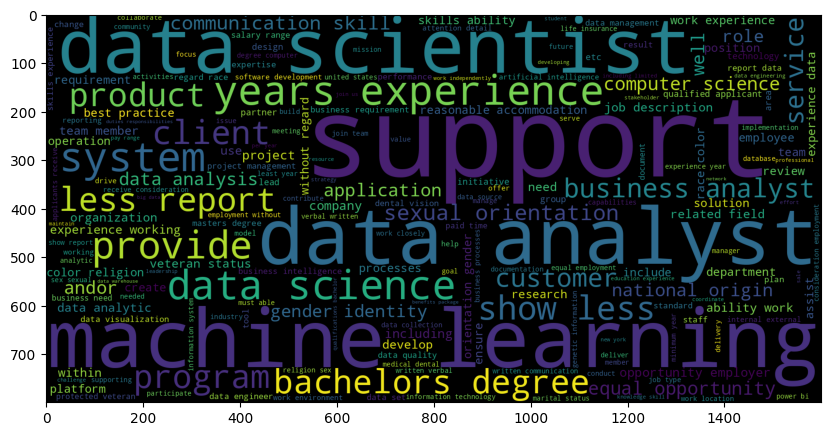

In [90]:
fig_geniune = WordCloud(width=1600, height=800, background_color='black').generate(data[data["updated_label"]==0]["textual_input"].str.cat(sep=' '))
plt.figure(figsize = (10, 7))
plt.imshow(fig_geniune)

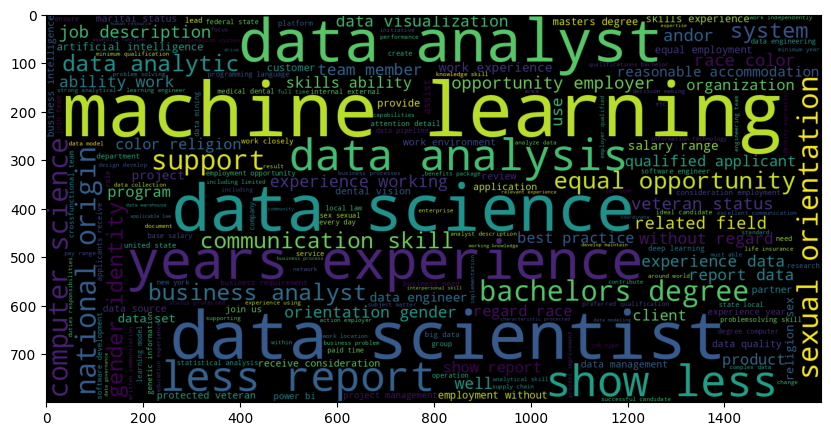

In [91]:
fig_fake = WordCloud(width=1600, height=800, background_color='black').generate(data[data["updated_label"]==1]["textual_input"].str.cat(sep=' '))
plt.figure(figsize = (10, 7))
plt.imshow(fig_fake)

#Predict

In [111]:
def predict_job_listing(raw_text):
  #process raw text
  processed_text = text_preprocessing(str(raw_text))
  #vectorize using trained tf-idf
  tf_idf_new_data = tf_idf_vec.transform([processed_text])
  final_input = tf_idf_new_data.toarray()
  # Load the model from the file
  with open('xgb.pkl', 'rb') as file:
      loaded_model = pickle.load(file)
  prediction = loaded_model.predict(final_input)
  if prediction == 0:
    return ({'raw_text': raw_text, 'preprocessed_text': processed_text, 'predicted_label': 'geniune'})
  if prediction == 1:
    return ({'raw_text': raw_text, 'preprocessed_text': processed_text, 'predicted_label': 'fake'})

In [117]:
raw_text = "Who We Are:\
At Haberfeld we align marketing, products, and people for sustained and significant organization growth by applying a strategy of consulting, marketing, training, \
and analytics. We like to live by 5 core values: Integrity, Excellence, Collaboration, Curiosity, Joy-in-the-Journey. The cherry-on-top is we are employee-owned and\
 love celebrating that. We reap the benefits of our hard work. How cool is that?\
Who We Want:\
We are seeking a dynamic individual to join our data team all while giving you an opportunity to own part of the company too! \
We are proud to be employee owned! Are you able to answer yes to any of the below?\
Do you dream in SQL? Are logical operators your love language?\
Do you get a charge out of analyzing numbers and finding correlation & trends in the details to help others excel?\
Do you enjoy pouring over key statistics to aid in the creation of numeric analysis and customer behavior modeling?\
Is working with methods such as predictive analytics, exploratory data analysis, spatial analysis, cluster analysis or grouping techniques something that gets your heart pumping?\
Do you enjoy thriving in a collaborative environment?\
Do you value life/work balance?\
What You’ll Do:\
Apply wizardry through modeling customer behaviors by evaluating account behaviors and creating marketing recommendations.\
Processing and analyzing customer data and marketing.\
Creating numeric analysis of consumer behaviors.\
Producing various reports including cross-sell modeling, segmentation, retention modeling and trending analytics.\
What You’ll Need:\
Self-starter mentality\
Expert knowledge or experience working with Transact-SQL with the ability to create and resolve complex SQL queries\
Knowledge of .NET, C#, JavaScript, Microsoft SQL Server, MS product suite, Address IQ and Match IQ from First Logic is favorable\
Required knowledge of MS Excel\
Ability to problem solve and a desire to learn\
Associates or Bachelor’s degree in Computer Science or related field preferred\
Show You the Money:\
At Haberfeld, we like to brag about our benefits. We will put together a package that will make your jaw drop. Here’s just a sampling of what to expect:\
Competitive base salary\
Bonus potential\
Responsible time off (RTO)\
Paid pregnancy-related leave\
Paid bonding leave\
Company holidays\
Extra Haberfeld holidays\
Medical, dental, vision insurance (we pay most for you!)\
Health Savings Account (HSA)\
Wellness screenings\
Disability insurance, group term life insurance and voluntary life insurance option\
Employee assistance (EAP)\
Employee Stock Ownership Plan (ESOP)\
401(k)\
Flexible work schedule - Tuesday / Thursday in-office days\
Casual office attire\
HealthJoy App/Wellable App\
Employee-owner education\
Recruiting bonus opportunity\
Free parking\
Summer early out Fridays\
On-site gym"

In [118]:
predict_job_listing(raw_text)

{'raw_text': 'Who We Are:At Haberfeld we align marketing, products, and people for sustained and significant organization growth by applying a strategy of consulting, marketing, training, and analytics. We like to live by 5 core values: Integrity, Excellence, Collaboration, Curiosity, Joy-in-the-Journey. The cherry-on-top is we are employee-owned and love celebrating that. We reap the benefits of our hard work. How cool is that?Who We Want:We are seeking a dynamic individual to join our data team all while giving you an opportunity to own part of the company too! We are proud to be employee owned! Are you able to answer yes to any of the below?Do you dream in SQL? Are logical operators your love language?Do you get a charge out of analyzing numbers and finding correlation & trends in the details to help others excel?Do you enjoy pouring over key statistics to aid in the creation of numeric analysis and customer behavior modeling?Is working with methods such as predictive analytics, exp